<a href="https://colab.research.google.com/github/MominaSiddiq/AI_Generated_vs_HumanCreated_Sketches/blob/main/AI_vs_Human_sketches_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Imports

import os
import random
import shutil
import collections
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import array_to_img
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input




## Fetch data
Fetching data from the drive in three folders (Splited Data): Test, Valid and Train  

In [3]:
# Fetch dataset from the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Fetch the split data from the drive

train_dir = '/content/drive/MyDrive/sketch_classification_project/train'
valid_dir = '/content/drive/MyDrive/sketch_classification_project/valid'
test_dir = '/content/drive/MyDrive/sketch_classification_project/test'

In [5]:
# Verify paths
for dir_path in [train_dir, valid_dir, test_dir]:
    if os.path.exists(dir_path):
        print(f"Directory exists: {dir_path}")
    else:
        print(f"Directory does not exist: {dir_path}")


Directory exists: /content/drive/MyDrive/sketch_classification_project/train
Directory exists: /content/drive/MyDrive/sketch_classification_project/valid
Directory exists: /content/drive/MyDrive/sketch_classification_project/test


## Creating Subsets
**Only need when perform on a subset of the dataset**

To create the subsets of the datasets, checking the format of the images, clear the directories and than copy the subsets of images to the new directories.

In [ ]:
# Check .jpg files in source directories
for category in ['AI', 'Human']:
    for dir_path in [train_dir, valid_dir, test_dir]:
        full_path = os.path.join(dir_path, category)
        if os.path.exists(full_path):
            all_images = [img for img in os.listdir(full_path) if img.endswith(( '.jpg'))]
            print(f"{len(all_images)} images found in {full_path}")

In [ ]:
# Clear subset directories
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Delete the directory and its contents
    os.makedirs(directory, exist_ok=True)  # Recreate the directory

# Clear subset directories
clear_directory(subset_train_dir + '/AI')
clear_directory(subset_train_dir + '/Human')
clear_directory(subset_valid_dir + '/AI')
clear_directory(subset_valid_dir + '/Human')
clear_directory(subset_test_dir + '/AI')
clear_directory(subset_test_dir + '/Human')

In [ ]:
# Function to copy a subset of images
def copy_subset(src_dir, dest_dir, num_images):
    for category in ['AI', 'Human']:
        src_category_dir = os.path.join(src_dir, category)
        dest_category_dir = os.path.join(dest_dir, category)

        # Filter only .png files
        all_images = [img for img in os.listdir(src_category_dir) if img.endswith('.jpg')]
        print(f"Found {len(all_images)} .jpg images in {src_category_dir}")

        # Ensure there are enough images to sample
        if len(all_images) < num_images:
            print(f"Not enough images in {src_category_dir}. Needed: {num_images}, Found: {len(all_images)}")
            num_images = len(all_images)  # Adjust to the available images

        # Randomly select images and copy
        selected_images = random.sample(all_images, num_images)
        for img in selected_images:
            print(f"Copying {img} to {dest_category_dir}")
            shutil.copy2(os.path.join(src_category_dir, img), os.path.join(dest_category_dir, img))


In [ ]:
# Paths for new subset directories
subset_dir = '/content/drive/MyDrive/sketch_classification_project_subset'
subset_train_dir = os.path.join(subset_dir, 'train')
subset_valid_dir = os.path.join(subset_dir, 'valid')
subset_test_dir = os.path.join(subset_dir, 'test')

# Create new directories for subset
os.makedirs(subset_train_dir + '/AI', exist_ok=True)
os.makedirs(subset_train_dir + '/Human', exist_ok=True)
os.makedirs(subset_valid_dir + '/AI', exist_ok=True)
os.makedirs(subset_valid_dir + '/Human', exist_ok=True)
os.makedirs(subset_test_dir + '/AI', exist_ok=True)
os.makedirs(subset_test_dir + '/Human', exist_ok=True)

In [ ]:
# Copy subset of images
total_image_to_process = 1000
train_images = 400
copy_subset(train_dir, subset_train_dir, 400)  # 400 per class for training
copy_subset(valid_dir, subset_valid_dir, 50)   # 50 per class for validation
copy_subset(test_dir, subset_test_dir, 50)    # 50 per class for testing

In [ ]:
# Check subset directory contents
for category in ['AI', 'Human']:
    for subset_dir in [subset_train_dir, subset_valid_dir, subset_test_dir]:
        subset_category_dir = os.path.join(subset_dir, category)
        print(f"{len(os.listdir(subset_category_dir))} images in {subset_category_dir}")

In [ ]:
# Update directories
subset_train_dir = '/content/drive/MyDrive/sketch_classification_project_subset/train'
subset_valid_dir = '/content/drive/MyDrive/sketch_classification_project_subset/valid'
subset_test_dir = '/content/drive/MyDrive/sketch_classification_project_subset/test'


## Pre-processing
Pre-processing of this images data include:


*   Re-sizing of images for efficient training.

*   Setting the batch size to 32 optimizes memory usage and speeds up training.



In [7]:

# Load training data
train_data = image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),  # Resize images to 128x128
    batch_size=32,          # Process in batches of 32
    label_mode='binary'     # Binary classification: AI vs Human
)

# Load validation data
valid_data = image_dataset_from_directory(
    valid_dir,
    image_size=(128, 128),
    batch_size=32,
    label_mode='binary'
)

# Load test data
test_data = image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=32,
    label_mode='binary'
)

Found 11774 files belonging to 2 classes.
Found 1120 files belonging to 2 classes.
Found 560 files belonging to 2 classes.


# **Training CNN Model From Scrach**

## Defining & Compiling CNN Model
Define and compile a basic CNN model for binary classification

1. Added Data Augmentation
2. Tried it by adding a dropout layer of 0.25.
3. Added a deeper layer.
4. Updated dropout layer to 0.4, 0.5 & 0.6.
5. Reduced learning rate to 0.0005.
6. Reduced learning rate again to 0.0003.

In [ ]:
# Define the updated CNN model
model = Sequential([
    # Data augmentation layers
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),

    # Convolutional layers with Batch Normalization and Dropout
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    Conv2D(512, (3, 3), activation='relu'),  # Added deeper layer for better feature extraction
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    Flatten(),

     # Fully connected layers
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.6),  # Increased dropout rate for robustness
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0003),  # Reduced learning rate to 0.0005 for stability & for better convergence reduce to 0.0003
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,098,369 (8.00 MB)

 Trainable params: 2,095,873 (8.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

## Training CNN Model
Train the model on the training data and validate on the validation set.
* Changed patience from 5 to 6 to 7.
* Changed the number of epochs.

In [ ]:
# Callbacks
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,   # Allow more patience for full dataset training
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=50,
    callbacks=[lr_schedule, early_stopping]
)


Epoch 1/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 892s 2s/step - accuracy: 0.5450 - loss: 0.9997 - val_accuracy: 0.6054 - val_loss: 0.7616 - learning_rate: 3.0000e-04
Epoch 2/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 866s 2s/step - accuracy: 0.5608 - loss: 0.8392 - val_accuracy: 0.6125 - val_loss: 0.7282 - learning_rate: 3.0000e-04
Epoch 3/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 878s 2s/step - accuracy: 0.5767 - loss: 0.7711 - val_accuracy: 0.5893 - val_loss: 0.7699 - learning_rate: 3.0000e-04
Epoch 4/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 894s 2s/step - accuracy: 0.5945 - loss: 0.7168 - val_accuracy: 0.6062 - val_loss: 0.6752 - learning_rate: 3.0000e-04
Epoch 5/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 921s 3s/step - accuracy: 0.6051 - loss: 0.6969 - val_accuracy: 0.6054 - val_loss: 0.6814 - learning_rate: 3.0000e-04
Epoch 6/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 955s 3s/step - accuracy: 0.6152 - loss: 0.6754 - val_accuracy: 0.5955 - val_loss: 0.6910 - learning_rate: 3.0000e-04
Epoch 7/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accur

## Visualizing Results


### Combined Accuracy & Loss Curves
This plot shows both training and validation accuracy and loss on the same figure.

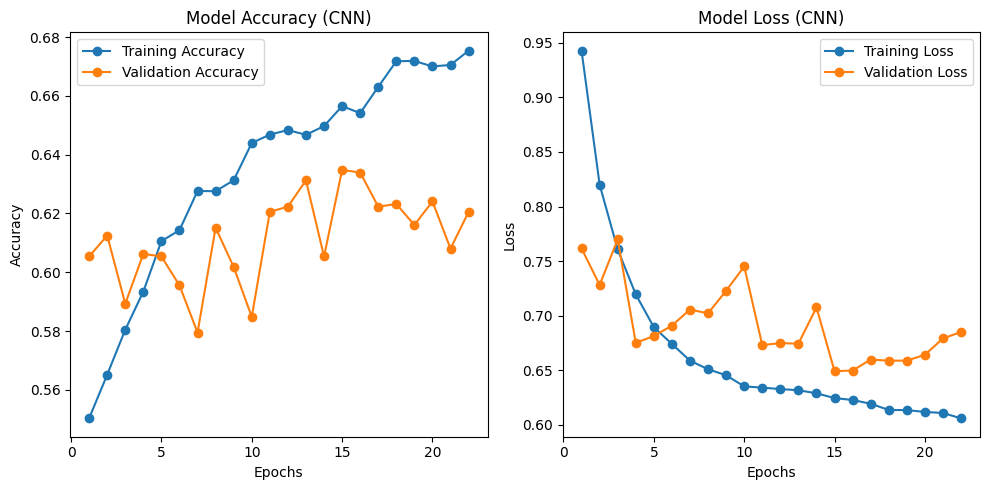

In [ ]:
# Example data from your model training; replace with your actual values
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Model Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Model Loss (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix
This gives an overview of true/false positives and negatives, which is crucial for classification tasks.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


<Figure size 800x600 with 0 Axes>

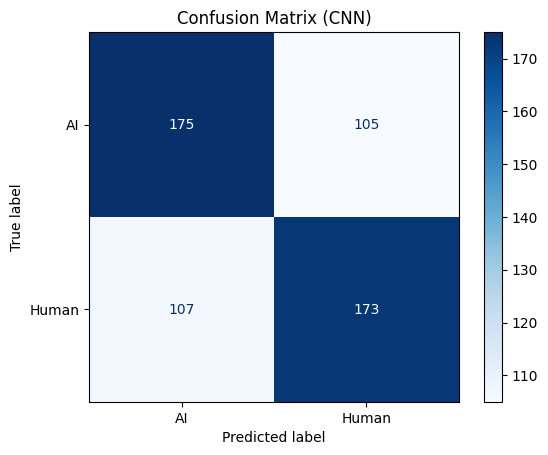

In [ ]:
# Initialize true and predicted labels
y_true = []
y_pred = []

# Iterate through the test dataset to generate predictions
for images, labels in test_data:
    preds = model.predict(images)  # Get predictions
    y_true.extend(labels.numpy())  # Append true labels
    y_pred.extend((preds > 0.5).astype(int).flatten())  # Threshold predictions

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AI", "Human"])

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (CNN)")
plt.show()

### Misclassified Examples
Showcase a few incorrectly predicted examples to analyze areas where the model struggles.

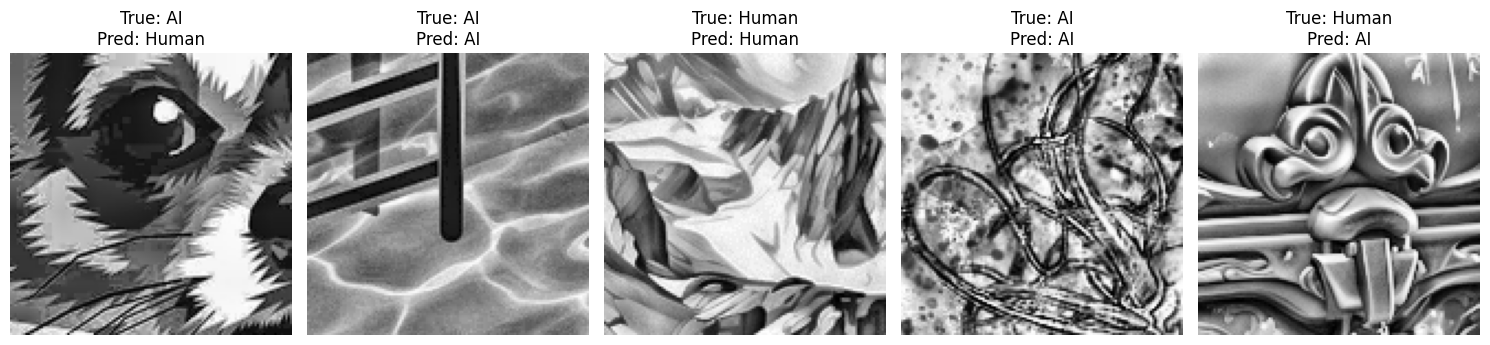

In [ ]:
# Misclassified examples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]
sampled_indices = random.sample(misclassified_indices, min(5, len(misclassified_indices)))

plt.figure(figsize=(15, 5))

for i, idx in enumerate(sampled_indices):
    # Find the corresponding image in the dataset
    for batch_images, batch_labels in test_data:
        if idx < len(batch_images):
            img = batch_images[idx]
            true_label = batch_labels[idx]
            break
        idx -= len(batch_images)

    pred_label = "AI" if y_pred[idx] else "Human"
    true_label = "AI" if true_label else "Human"

    plt.subplot(1, 5, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()



# **Transfer Learning**
Doing it with transfer learning technique by using ResNet50 and VGG16 and analyze the results.




## ResNet Model


### Defining & Compiling the ResNet50 Model
Using the ResNet50 pre-trained model and add custom layers for binary classification.

In [ ]:
# Load pre-trained ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers initially
base_model.trainable = False

# Define the custom model with in-model augmentations
model = Sequential([
    # Augmentation Layers
    Input(shape=(128, 128, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(factor=(-0.2, 0.2)),

    # Pre-trained ResNet50 base
    base_model,

    # Additional Conv2D Layer (if necessary, for fine feature extraction)
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    GlobalAveragePooling2D(),  # GAP reduces dimensions after Conv2D layers

    # Dense layers with L2 regularization and Dropout
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness (RandomBrightness) │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 2, 2, 32)            │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2, 2, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           8,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,219,169 (92.39 MB)

 Trainable params: 631,393 (2.41 MB)

 Non-trainable params: 23,587,776 (89.98 MB)

### Add Callbacks
Using callbacks for early stopping and learning rate adjustments to improve performance.

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop after 5 epochs of no improvement
    restore_best_weights=True,
    verbose=1  # Added verbosity for better logging
)

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

### Training the ResNet50 Model
Train the model using the subset.

In [ ]:
# Initial Training
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=50,
    callbacks=[early_stopping, lr_schedule],
    verbose=1  # Ensure training process is logged
)

Epoch 1/50
  3/368 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.5104 - loss: 3.6143

KeyboardInterrupt: 

### Fine-Tune the Model
After initial training, unfreeze some layers of the pre-trained ResNet50 model for fine-tuning.

In [ ]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Optional: Print a summary of the trainable layers
print("Number of trainable layers after unfreezing:", len(model.trainable_variables))

# Fine-Tune the Model
history_fine_tune = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=50,
    callbacks=[
        early_stopping,  # Stop early if no improvement
        lr_schedule      # Reduce learning rate on plateau
    ],
    verbose=1  # Show detailed training progress
)

Number of trainable layers after unfreezing: 222
Epoch 1/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 135s 262ms/step - accuracy: 0.7331 - loss: 0.6185 - val_accuracy: 0.6661 - val_loss: 0.7882 - learning_rate: 1.0000e-04
Epoch 2/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 136s 251ms/step - accuracy: 0.7763 - loss: 0.5398 - val_accuracy: 0.6393 - val_loss: 1.1005 - learning_rate: 1.0000e-04
Epoch 3/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 143s 253ms/step - accuracy: 0.7906 - loss: 0.5120 - val_accuracy: 0.6884 - val_loss: 0.8151 - learning_rate: 1.0000e-04
Epoch 4/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 144s 258ms/step - accuracy: 0.8112 - loss: 0.4641 - val_accuracy: 0.7009 - val_loss: 0.7536 - learning_rate: 1.0000e-04
Epoch 5/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 253ms/step - accuracy: 0.8286 - loss: 0.4250 - val_accuracy: 0.6705 - val_loss: 1.0053 - learning_rate: 1.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


### Evaluate the Model
Evaluating the model on the validation data.

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(valid_data)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.6573 - loss: 0.8449
Validation Loss: 0.788191020488739
Validation Accuracy: 0.6660714149475098


### Combined Accuracy & Loss Curves

The plot shows both training and validation accuracy and loss on the same figure.

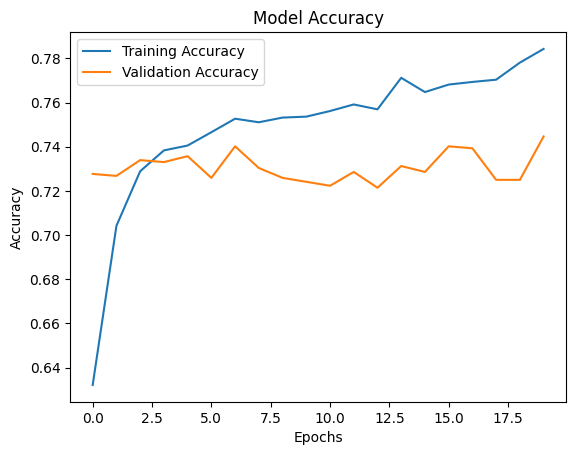

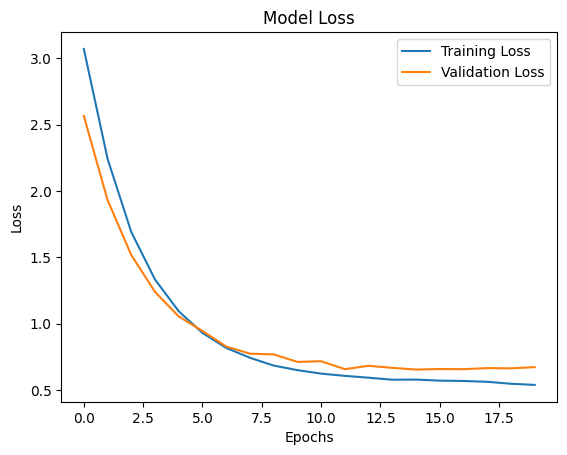

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

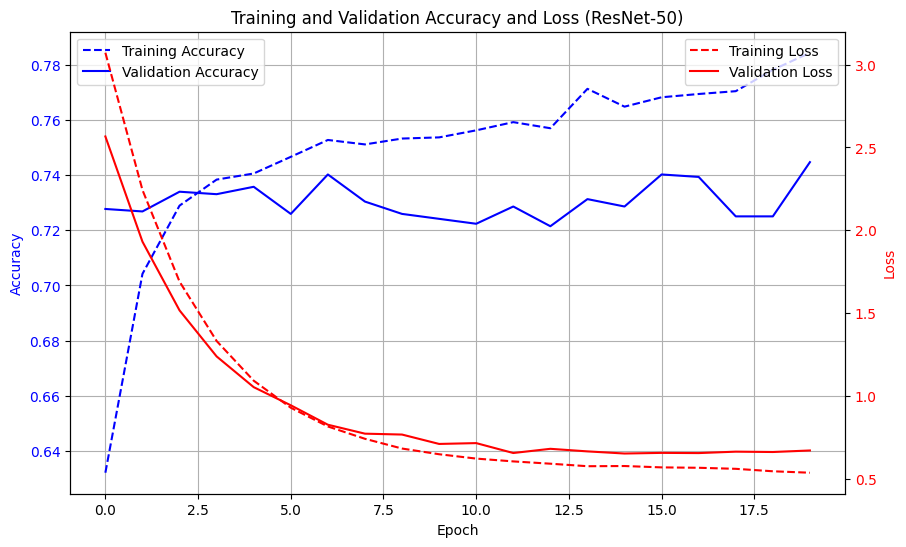

In [ ]:
# Plot training/validation accuracy and loss in one figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy on the left y-axis
ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linestyle='--')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot loss on the right y-axis
ax2 = ax1.twinx()
ax2.plot(history.history['loss'], label='Training Loss', color='red', linestyle='--')
ax2.plot(history.history['val_loss'], label='Validation Loss', color='red')
ax2.set_ylabel('Loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('Training and Validation Accuracy and Loss (ResNet-50)')
plt.show()

### Confusion Matrix

This gives an overview true/false positives and negatives of the ResNet-50 model, which is crucial for classification tasks.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


<Figure size 800x600 with 0 Axes>

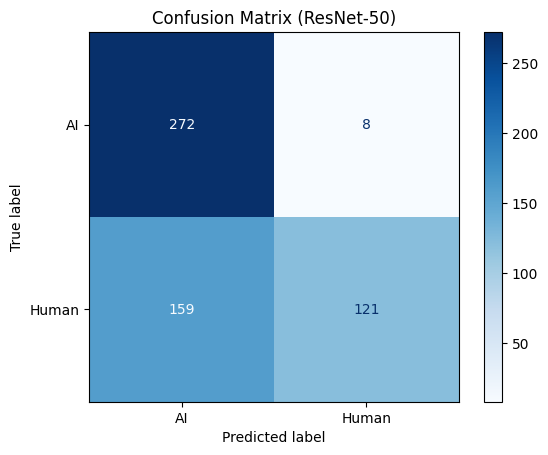

In [ ]:
# Initialize true and predicted labels
y_true = []
y_pred = []

# Iterate through the test dataset to generate predictions
for images, labels in test_data:
    preds = model.predict(images)  # Get predictions
    y_true.extend(labels.numpy())  # Append true labels
    y_pred.extend((preds > 0.5).astype(int).flatten())  # Threshold predictions

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AI", "Human"])

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (ResNet-50)")
plt.show()

### Misclassified Examples

Showcase a few incorrectly predicted examples to analyze areas where the ResNet-50 model struggles.

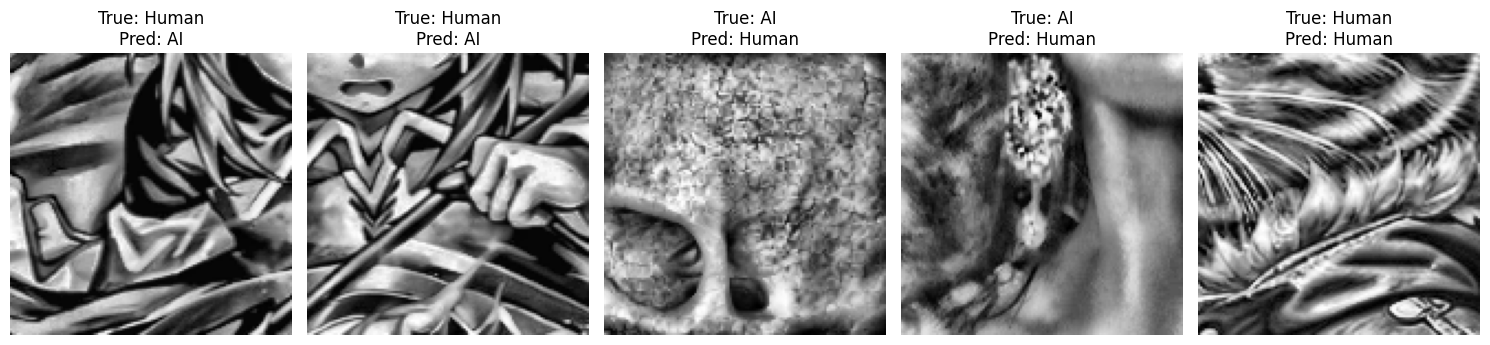

In [ ]:
# Misclassified examples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]
sampled_indices = random.sample(misclassified_indices, min(5, len(misclassified_indices)))

plt.figure(figsize=(15, 5))

for i, idx in enumerate(sampled_indices):
    # Find the corresponding image in the dataset
    for batch_images, batch_labels in test_data:
        if idx < len(batch_images):
            img = batch_images[idx]
            true_label = batch_labels[idx]
            break
        idx -= len(batch_images)

    pred_label = "AI" if y_pred[idx] else "Human"
    true_label = "AI" if true_label else "Human"

    plt.subplot(1, 5, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### ROC Curve
The Receiver Operating Characteristic (ROC) curve helps visualize the trade-off between the true positive rate (sensitivity) and the false positive rate (1-specificity) at various thresholds.

18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step


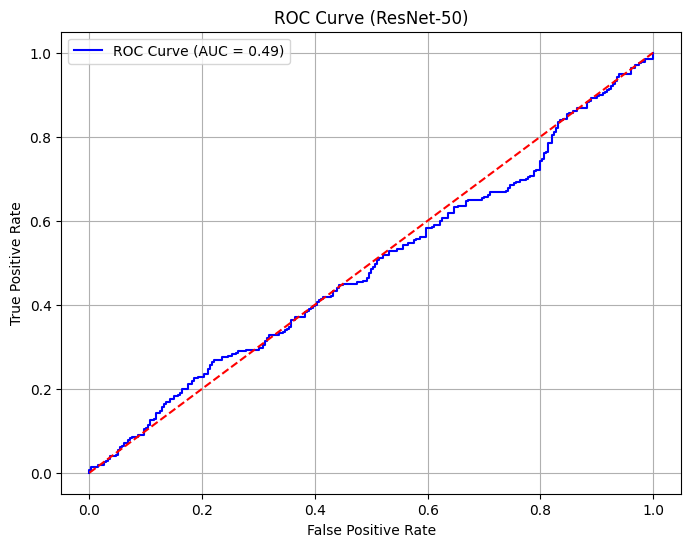

In [ ]:
# Convert y_true and y_pred to numpy arrays
y_true_np = np.array(y_true)
y_pred_np = np.array([p[0] for p in model.predict(test_data)])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_np, y_pred_np)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve (ResNet-50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

### Visualizing Prediction
Testing the model on a few validation images and visualize the predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step


<ipython-input-24-656631ccc2ee>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = class_names[int(predicted_labels[i])]


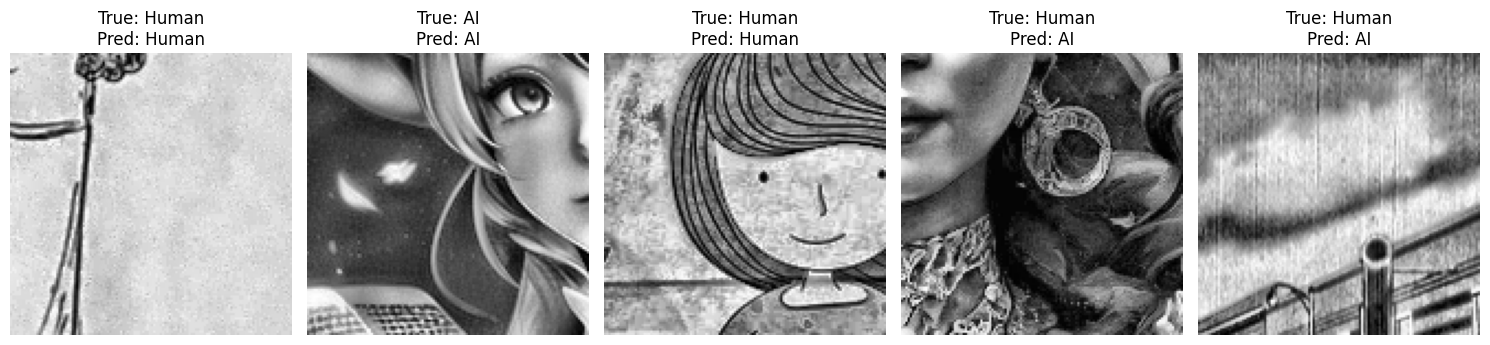

In [ ]:
def visualize_predictions(model, dataset, class_names, num_images=5):
    images, labels = next(iter(dataset))
    predictions = model.predict(images[:num_images])
    predicted_labels = (predictions > 0.5).astype("int32")  # Convert probabilities to binary labels

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(array_to_img(images[i]))
        true_label = class_names[int(labels[i])]
        predicted_label = class_names[int(predicted_labels[i])]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Define class names
class_names = ['AI', 'Human']

# Visualize predictions
visualize_predictions(model, valid_data, class_names)

## VGG Model


### Defining & Compiling the VGG16 Model
Using the VGG16 pre-trained model and add custom layers for binary classification.

In [8]:
# Load pre-trained VGG16 model without the top layers
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers (do not train these layers initially)
base_model_vgg.trainable = False

# Define the custom model on top of VGG16
model_vgg = Sequential([
    base_model_vgg,  # Pre-trained base model
    GlobalAveragePooling2D(),  # Global average pooling to replace flattening

    # Add dense layers with higher dropout and L2 regularization
    Dense(256, activation='relu', kernel_regularizer=l2(0.002)),  # Increased L2 regularization
    Dropout(0.5),  # Dropout to reduce overfitting
    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),  # Additional dense layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model_vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,879,041 (56.76 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Add Callbacks
Using callbacks, as before for early stopping and learning rate adjustments to improve performance.

In [9]:
# Define callbacks
early_stopping_vgg = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop after 5 epochs of no improvement
    restore_best_weights=True
)

lr_schedule_vgg = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

### Train the VGG16 Model
Training the VGG16 model using the subset.

In [1]:
# Train the model (Initial Training)
history_vgg = model_vgg.fit(
    train_data,
    validation_data=valid_data,
    epochs=50,
    callbacks=[early_stopping_vgg, lr_schedule_vgg]
)


NameError: name 'model_vgg' is not defined

### Fine-Tune the Model
After the initial training, unfreeze some layers of the VGG16 base model for fine-tuning.

In [ ]:
# Unfreeze the last 10–15 layers of the base model for fine-tuning
for layer in base_model_vgg.layers[-15:]:  # Adjust the number of layers to unfreeze
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_vgg_fine_tune = model_vgg.fit(
    train_data,
    validation_data=valid_data,
    epochs=50,
    callbacks=[early_stopping_vgg, lr_schedule_vgg]
)

Epoch 1/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 119s 257ms/step - accuracy: 0.6293 - loss: 0.7798 - val_accuracy: 0.7143 - val_loss: 0.6833 - learning_rate: 1.0000e-04
Epoch 2/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 69s 187ms/step - accuracy: 0.7251 - loss: 0.6519 - val_accuracy: 0.7054 - val_loss: 0.6441 - learning_rate: 1.0000e-04
Epoch 3/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 82s 188ms/step - accuracy: 0.7467 - loss: 0.5833 - val_accuracy: 0.7312 - val_loss: 0.5986 - learning_rate: 1.0000e-04
Epoch 4/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 67s 182ms/step - accuracy: 0.7612 - loss: 0.5397 - val_accuracy: 0.7339 - val_loss: 0.5853 - learning_rate: 1.0000e-04
Epoch 5/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 69s 188ms/step - accuracy: 0.7928 - loss: 0.4888 - val_accuracy: 0.7366 - val_loss: 0.6688 - learning_rate: 1.0000e-04
Epoch 6/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 82s 188ms/step - accuracy: 0.8286 - loss: 0.4218 - val_accuracy: 0.7179 - val_loss: 0.8062 - learning_rate: 1.0000e-04
Epoch 7/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17

### Evaluate the VGG16 Model
Evaluate the performance of the fine-tuned model on the validation dataset.

In [ ]:
# Evaluate the model
loss_vgg, accuracy_vgg = model_vgg.evaluate(valid_data)
print(f"Validation Loss (VGG16): {loss_vgg}")
print(f"Validation Accuracy (VGG16): {accuracy_vgg}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.7456 - loss: 0.5718
Validation Loss (VGG16): 0.5853131413459778
Validation Accuracy (VGG16): 0.7339285612106323


### Visualize Results
Plot the accuracy and loss curves to understand the model's performance.

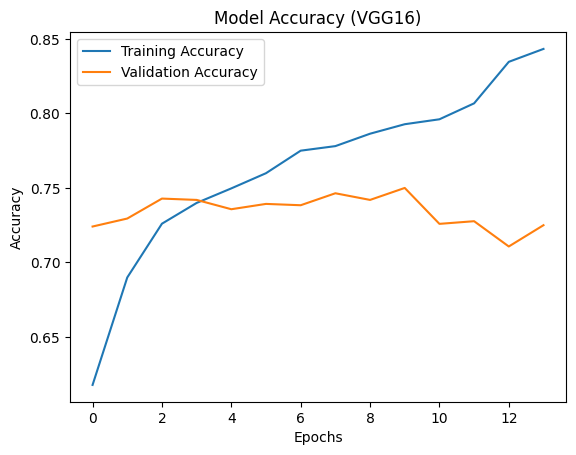

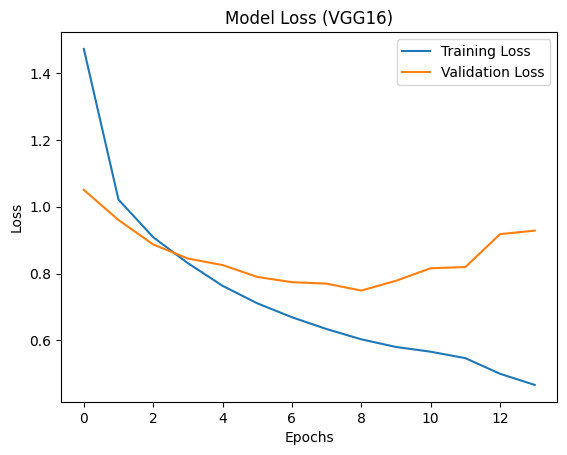

In [ ]:
# Plot training and validation accuracy
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (VGG16)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (VGG16)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Visualizing Prediction

Testing the VGG16 model on a few validation images and visualize the predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


<ipython-input-19-648549fb3f2b>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = class_names[int(predicted_labels[i])]


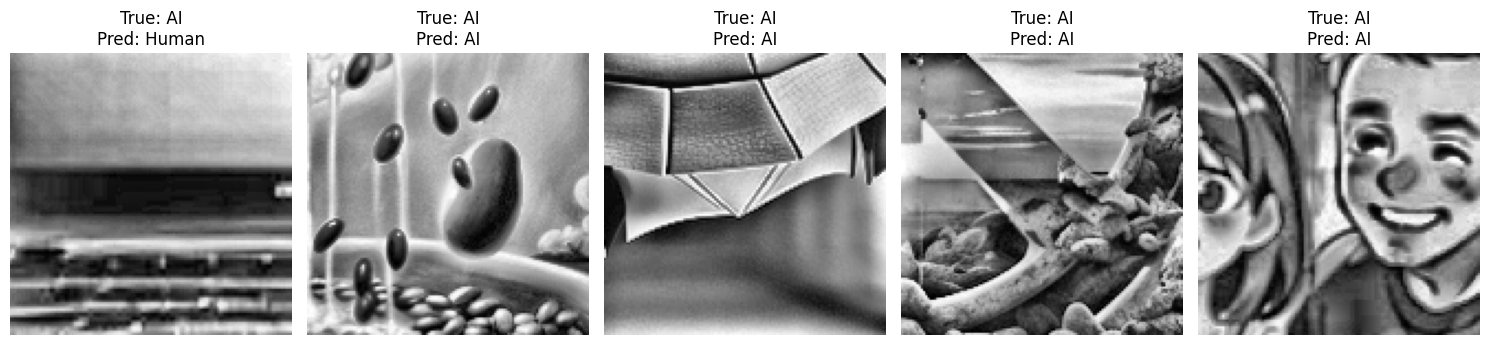

In [ ]:
def visualize_predictions(model, dataset, class_names, num_images=5):
    images, labels = next(iter(dataset))
    predictions = model.predict(images[:num_images])
    predicted_labels = (predictions > 0.5).astype("int32")  # Convert probabilities to binary labels

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(array_to_img(images[i]))
        true_label = class_names[int(labels[i])]
        predicted_label = class_names[int(predicted_labels[i])]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Define class names
class_names = ['AI', 'Human']

# Visualize predictions
visualize_predictions(model_vgg, valid_data, class_names)

### Combined Accuracy & Loss Curves

The plot shows both training and validation accuracy and loss on the same figure.

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot training and validation accuracy/loss
def plot_training_validation(history, model_name="VGG-16"):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(10, 6))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', linestyle='--', color='blue')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='blue')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', linestyle='--', color='red')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_validation(history_vgg, model_name="VGG-16")

### Confusion Matrix

This gives an overview true/false positives and negatives of the VGG-16 model, which is crucial for classification tasks.

In [ ]:
# Evaluate the model on validation data
y_true = []
y_pred = []

for images, labels in valid_data:
    preds = model_vgg.predict(images)
    y_true.extend(labels)
    y_pred.extend(preds)
    if len(y_true) >= valid_data.samples:  # Stop after one pass through the validation data
        break

y_true = np.array(y_true)
y_pred = np.array(y_pred) > 0.5  # Convert probabilities to binary predictions

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AI", "Human"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (VGG-16)")
plt.show()

### Misclassified Examples

Showcase a few incorrectly predicted examples to analyze areas where the VGG-16 model struggles.

In [ ]:
# Plot misclassified images
def plot_misclassified_images(valid_data, model, num_images=5):
    misclassified = []
    for images, labels in valid_data:
        preds = model.predict(images)
        for i in range(len(labels)):
            if len(misclassified) >= num_images:
                break
            true_label = "AI" if labels[i] == 0 else "Human"
            predicted_label = "AI" if preds[i] < 0.5 else "Human"
            if true_label != predicted_label:
                misclassified.append((images[i], true_label, predicted_label))
        if len(misclassified) >= num_images:
            break

    # Plot the misclassified images
    plt.figure(figsize=(15, 5))
    for i, (image, true_label, predicted_label) in enumerate(misclassified):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.tight_layout()
    plt.show()

# Call the function
plot_misclassified_images(valid_data, model_vgg, num_images=5)